In [52]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

np.random.seed(seed=1)

In [53]:
# データセットを用意
X, t = sklearn.datasets.make_circles(n_samples=100, shuffle=False, factor=0.3, noise=0.1)
T = np.zeros((100, 2))
T[t == 1, 1] = 1
T[t == 0, 0] = 1

# 可視化のために2クラスを別の変数に分ける
x_red = X[t == 0]
x_blue = X[t == 1]

print('shape of X: {}'.format(X.shape))
print('shape of T: {}'.format(T.shape))

shape of X: (100, 2)
shape of T: (100, 2)


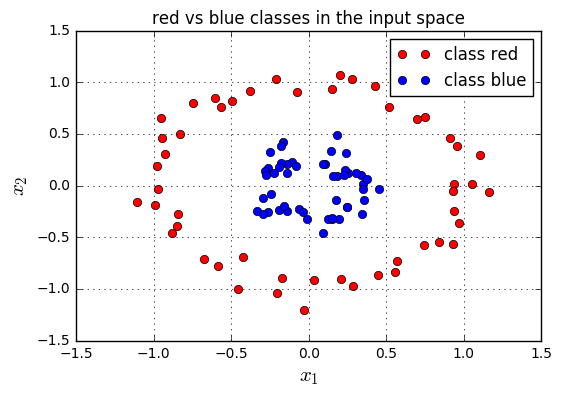

In [54]:
plt.plot(x_red[:, 0], x_red[:, 1], 'ro', label='class red')
plt.plot(x_blue[:, 0], x_blue[:, 1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classes in the input space')
plt.show()

In [55]:
# ロジスティック関数
def logistic(z):
    return 1 / (1 + np.exp(-z))

# softmax
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

# 隠れ層の出力
def hidden_activations(X, Wh, bh):
    return logistic(X.dot(Wh) + bh)

# 出力層の出力
def output_activations(H, Wo, bo):
    return softmax(H.dot(Wo) + bo)

# ニューラルネットを定義
def nn(X, Wh, bh, Wo, bo):
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)

# 入力からクラスを予測する関数
def nn_predict(X, Wh, bh, Wo, bo):
    return np.around(nn(X, Wh, bh, Wo, bo))


In [56]:
# コスト関数
def cost(Y, T):
    return -np.multiply(T, np.log(Y)).sum()

# 出力層の誤差
def error_output(Y, T):
    return Y - T

# コスト関数のWoでの微分
def gradient_weight_out(H, Eo):
    return H.T.dot(Eo)

# コスト関数のboでの微分
def gradient_bias_out(Eo):
    return np.sum(Eo, axis=0, keepdims=True)

In [57]:
# 隠れ層の誤差
def error_hidden(H, Wo, Eo):
    # H * (1 - H) * (E, Wo^T)
    return np.multiply(np.multiply(H, (1 - H)), Eo.dot(Wo.T))

# コスト関数のWhでの微分
def gradient_weight_hidden(X, Eh):
    return X.T.dot(Eh)

# コスト関数のbhでの微分
def gradient_bias_hidden(Eh):
    return np.sum(Eh, axis=0, keepdims=True)

In [58]:
# 重みとバイアスの初期化
init_var = 1
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

# バックプロパゲーションで微分を計算
# (1) 順方向に出力を計算
H = hidden_activations(X, Wh, bh)
Y = output_activations(H, Wo, bo)

# (2) 逆方向に微分を計算
Eo = error_output(Y, T)
JWo = gradient_weight_out(H, Eo)
Jbo = gradient_bias_out(Eo)

Eh = error_hidden(H, Wo, Eo)
JWh = gradient_weight_hidden(X, Eh)
Jbh = gradient_bias_hidden(Eh)

In [59]:
# パラメータを1つのリストにまとめておく
params = [Wh, bh, Wo, bo]

# バックプロパゲーションで計算した微分
grad_params = [JWh, Jbh, JWo, Jbo]

# 数値微分に使うイプシロン
eps = 0.0001

# Gradient checking
for p_idx in range(len(params)):
    for row in range(params[p_idx].shape[0]):
        for col in range(params[p_idx].shape[1]):
            # 対象のパラメータ行列をコピー
            p_matrix_min = params[p_idx].copy()
            p_matrix_min[row, col] -= eps
            p_matrix_plus = params[p_idx].copy()
            p_matrix_plus[row, col] += eps
            
            # paramsをコピーし、更新した行列で置き換える
            params_min = params[:]
            params_min[p_idx] = p_matrix_min
            params_plus = params[:]
            params_plus[p_idx] = p_matrix_plus
            
            # 数値微分を計算
            grad_num = (cost(nn(X, *params_plus), T) - cost(nn(X, *params_min), T)) / (2 * eps)
            
            # np.iscloseでバックプロパゲーションでの微分と数値微分の値が近いか確認
            if not np.isclose(grad_num, grad_params[p_idx][row, col]):
                raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(
                    float(grad_num), float(grad_params[p_idx][row, col])))

print('No gradient errors found')

No gradient errors found


In [60]:
# バックプロパゲーションで微分を計算する関数
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    
    return [JWh, Jbh, JWo, Jbo]

# 速度を更新する関数
def update_velocity(X, T, ls_of_params, Vs, momentum_term, learning_rate):
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    return [momentum_term * V - learning_rate * J for V, J in zip(Vs, Js)]

# パラメータを更新する関数
def update_params(ls_of_params, Vs):
    # ls_of_params = [Wh, bh, Wo, bo]
    # Vs = [VWh, Vbh, VWo, Vbo]
    return [P + V for P, V in zip(ls_of_params, Vs)]

In [61]:
# バックプロパゲーションの実行

# 重みとバイアスの初期化
init_var = 0.1
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

learning_rate = 0.02
momentum_term = 0.9

Vs = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]

# イテレーション部分
num_of_iterations = 300
lr_update = learning_rate / num_of_iterations
ls_costs = [cost(nn(X, Wh, bh, Wo, bo), T)] # イテレーションごとのコストを保存しておく

for i in range(num_of_iterations):
    Vs = update_velocity(X, T, [Wh, bh, Wo, bo], Vs, momentum_term, learning_rate)
    Wh, bh, Wo, bo = update_params([Wh, bh, Wo, bo], Vs)
    ls_costs.append(cost(nn(X, Wh, bh, Wo, bo), T))


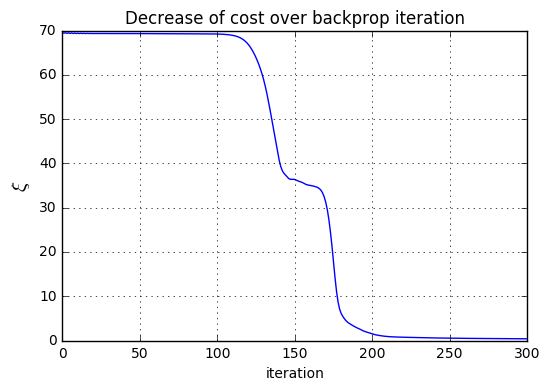

In [62]:
plt.plot(ls_costs, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

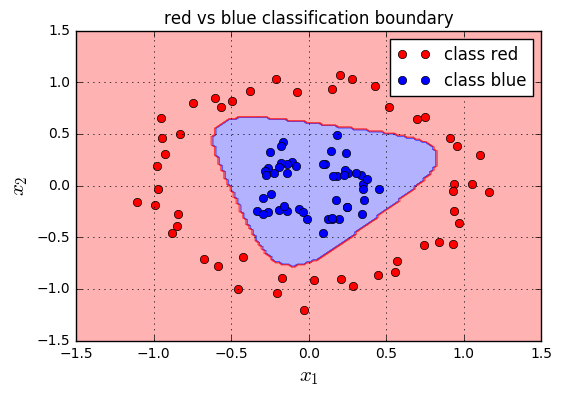

In [64]:
# 決定境界の可視化
num_of_xs = 200
xs1 = np.linspace(-2, 2, num=num_of_xs)
xs2 = np.linspace(-2, 2, num=num_of_xs)
xx, yy = np.meshgrid(xs1, xs2)

classification_plane = np.zeros((num_of_xs, num_of_xs))
for i in range(num_of_xs):
    for j in range(num_of_xs):
        pred = nn_predict(np.array([xx[i, j], yy[i, j]]), Wh, bh, Wo, bo)
        classification_plane[i, j] = pred[0, 0]
        
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('r', alpha=0.3)
    ])

plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.plot(x_red[:, 0], x_red[:, 1], 'ro', label='class red')
plt.plot(x_blue[:, 0], x_blue[:, 1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classification boundary')
plt.show()

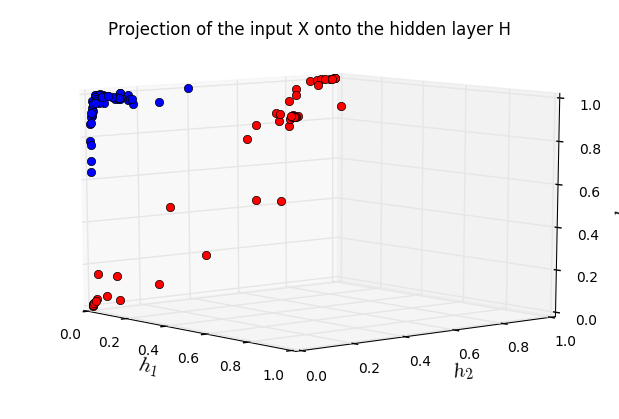

In [65]:
# 隠れ層の値をプロットしてみる
H_blue = hidden_activations(x_blue, Wh, bh)
H_red = hidden_activations(x_red, Wh, bh)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(np.ravel(H_blue[:, 0]), np.ravel(H_blue[:, 1]), np.ravel(H_blue[:, 2]), 'bo')
ax.plot(np.ravel(H_red[:, 0]), np.ravel(H_red[:, 1]), np.ravel(H_red[:, 2]), 'ro')
ax.set_xlabel('$h_1$', fontsize=15)
ax.set_ylabel('$h_2$', fontsize=15)
ax.set_zlabel('$h_3$', fontsize=15)
ax.view_init(elev=10, azim=-40)
plt.title('Projection of the input X onto the hidden layer H')
plt.grid()
plt.show()

In [93]:
# モーメンタムでなく最急降下法を使用して最適化してみる
def gradient_decent_params_update(X, T, Wh, bh, Wo, bo, learning_rate):
    JWh, Jbh, JWo, Jbo = backprop_gradients(X, T, Wh, bh, Wo, bo)
    return [W - learning_rate * dW for W, dW in zip([Wh, bh, Wo, bo], [JWh, Jbh, JWo, Jbo])]

# バックプロパゲーションの実行
# 重みとバイアスの初期化
init_var = 0.1
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

learning_rate = 0.2

# イテレーション部分
num_of_iterations = 300
lr_update = learning_rate / num_of_iterations
ls_costs = [cost(nn(X, Wh, bh, Wo, bo), T)] # イテレーションごとのコストを保存しておく

for i in range(num_of_iterations):
    learning_rate -= lr_update
    Wh, bh, Wo, bo = gradient_decent_params_update(X, T, Wh, bh, Wo, bo, learning_rate)
    ls_costs.append(cost(nn(X, Wh, bh, Wo, bo), T))

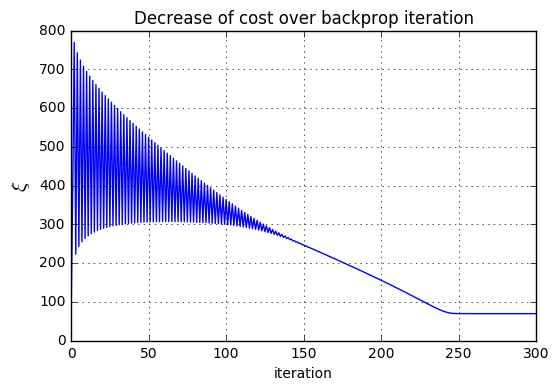

In [94]:
plt.plot(ls_costs, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

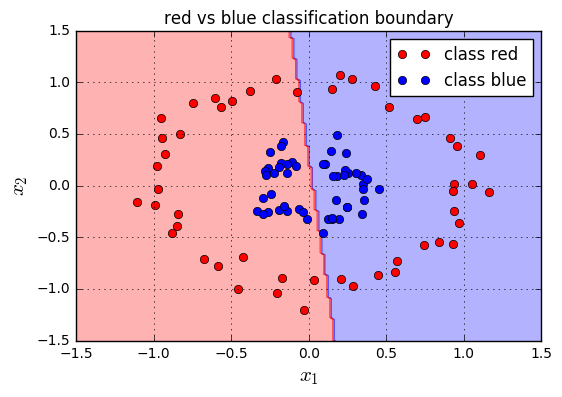

In [95]:
# 決定境界の可視化
num_of_xs = 200
xs1 = np.linspace(-2, 2, num=num_of_xs)
xs2 = np.linspace(-2, 2, num=num_of_xs)
xx, yy = np.meshgrid(xs1, xs2)

classification_plane = np.zeros((num_of_xs, num_of_xs))
for i in range(num_of_xs):
    for j in range(num_of_xs):
        pred = nn_predict(np.array([xx[i, j], yy[i, j]]), Wh, bh, Wo, bo)
        classification_plane[i, j] = pred[0, 0]
        
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.3),
        colorConverter.to_rgba('r', alpha=0.3)
    ])

plt.contourf(xx, yy, classification_plane, cmap=cmap)
plt.plot(x_red[:, 0], x_red[:, 1], 'ro', label='class red')
plt.plot(x_blue[:, 0], x_blue[:, 1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classification boundary')
plt.show()

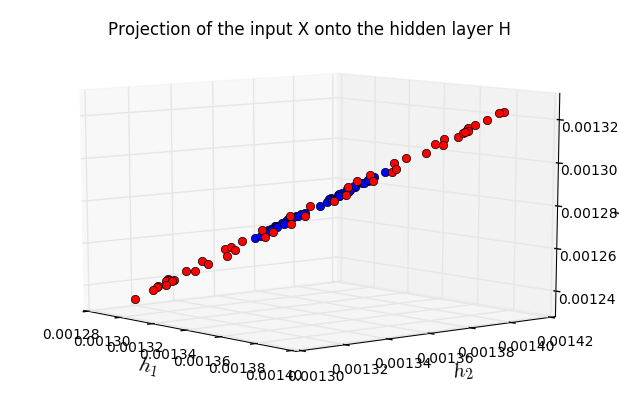

In [96]:
# 隠れ層の値をプロットしてみる
H_blue = hidden_activations(x_blue, Wh, bh)
H_red = hidden_activations(x_red, Wh, bh)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(np.ravel(H_blue[:, 0]), np.ravel(H_blue[:, 1]), np.ravel(H_blue[:, 2]), 'bo')
ax.plot(np.ravel(H_red[:, 0]), np.ravel(H_red[:, 1]), np.ravel(H_red[:, 2]), 'ro')
ax.set_xlabel('$h_1$', fontsize=15)
ax.set_ylabel('$h_2$', fontsize=15)
ax.set_zlabel('$h_3$', fontsize=15)
ax.view_init(elev=10, azim=-40)
plt.title('Projection of the input X onto the hidden layer H')
plt.grid()
plt.show()